In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

measurements_firstrow = session.query(Measurements).first()
measurements_firstrow.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f66ac66c10>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set. Keys: id, prcp, tobs, station, date
# ref: https://www.programiz.com/python-programming/methods/list/sort
col_size = len(session.query(Measurements.date).all())
measurements_recentdate = max(session.query(Measurements.date).all())
print(f"The most recent date in the database is {measurements_recentdate[0]}")


The most recent date in the database is 2017-08-23


In [29]:
# Identify the datatypes present in the database

inspector = inspect(engine)
columns = inspector.get_columns('measurement')

for column in columns: 
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Approach: identify the datatypes of everything in the database to determine how to query the specific dates, then 
# use a nested for loop to extract the relevant data from every class for each row you iterate through
# then store each line of information in a new DF that you can manipulate for the viz
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# ref: https://www.gormanalysis.com/blog/python-pandas-for-your-grandpa-4-2-dates-and-times/
# ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html
# ref: https://www.programiz.com/python-programming/datetime/strftime
# ref: https://www.journaldev.com/23365/python-string-to-datetime-strptime
# ref: https://datatofish.com/strings-to-datetime-pandas/


query_enddate = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
query_startdate = dt.datetime.strftime(dt.datetime.strptime(query_enddate[0], '%Y-%m-%d') - dt.timedelta(days=365), '%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores

measurements_query = session.query(Measurements.id, Measurements.station, Measurements.date, Measurements.prcp, 
                                   Measurements.tobs).\
                    filter(Measurements.date >= query_startdate).\
                    filter(Measurements.date <= query_enddate[0]).\
                    order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.DataFrame([{ "Date": query[2],
                                "Precipitation": query[3]} for query in measurements_query])

# Sort the dataframe by date
measurements_df = measurements_df.sort_values('Date', ascending=True)
measurements_df = measurements_df.set_index('Date')


# Use Pandas Plotting with Matplotlib to plot the data
measurements_df = measurements_df.fillna(0)
measurements_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_df.groupby('Date').describe()

Precipitation                                                      
                   count      mean       std  min     25%    50%     75%   max
Date                                                                          
2016-08-23           7.0  0.387143  0.667126  0.0  0.0100  0.050  0.4250  1.79
2016-08-24           7.0  1.332857  0.966535  0.0  0.6500  1.450  2.1500  2.28
2016-08-25           7.0  0.077143  0.071813  0.0  0.0300  0.080  0.0950  0.21
2016-08-26           6.0  0.016667  0.016330  0.0  0.0025  0.015  0.0275  0.04
2016-08-27           6.0  0.053333  0.077632  0.0  0.0000  0.010  0.0950  0.18
...                  ...       ...       ...  ...     ...    ...     ...   ...
2017-08-19           4.0  0.022500  0.045000  0.0  0.0000  0.000  0.0225  0.09
2017-08-20           3.0  0.003333  0.005774  0.0  0.0000  0.000  0.0050  0.01
2017-08-21           4.0  0.145000  0.276827  0.0  0.0000  0.010  0.1550  0.56
2017-08-22           3.0  0.166667  0.288675  0.0  0.0000  0.000  0.2500  0.50
2017-08-23           4.0  0.132500  0.215000  0.0  0.0000  0.040  0.1725  0.45

[366 rows x 8 columns]

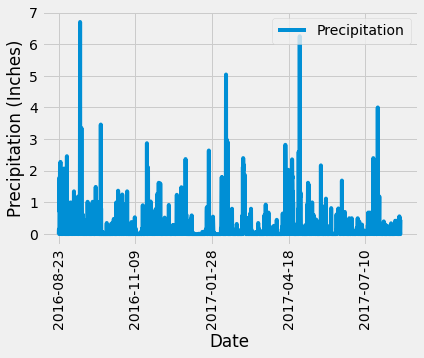

In [32]:
# Use Pandas to plot the precipitation data
# ref: https://stackoverflow.com/questions/32244019/how-to-rotate-x-axis-tick-labels-in-pandas-barplot
prcp_plot = measurements_df.plot()
plt.xticks(rotation=90)
lg = plt.legend(loc='upper right')
xlbl = plt.xlabel('Date')
ylbl = plt.ylabel("Precipitation (Inches)")

# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
# Keys: name, id, longitude, elevation, station, latitude
stations_firstrow = session.query(Stations).first()
stations_firstrow.__dict__

station_count_query = len(session.query(Stations.station).all())
print(f"The total number of stations is {station_count_query}")

The total number of stations is 9


In [60]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# ref: https://docs.sqlalchemy.org/en/14/orm/query.html
# ref: https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending

activestations_query = session.query(Measurements.station, func.count(Measurements.station)).\
        group_by(Measurements.station).\
        order_by(func.count(Measurements.station).desc()).all()

activestations_query
max_activestation = activestations_query[0]
print(f"The following list shows the stations with the most activity in descending order: ")
activestations_query

The following list shows the stations with the most activity in descending order: 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# The most active station is USC00519281: Waihee

max_tob = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
                        filter(Measurements.station == max_activestation[0]).all()

print(f"The minimum observed temperature at station {max_activestation[0]}, Waihee was {max_tob[0][0]} ")
print(f"The maximum observed temperature at station {max_activestation[0]}, Waihee was {max_tob[0][1]} ")
print(f"The average observed temperature at station {max_activestation[0]}, Waihee was {max_tob[0][2]} ")

The minimum observed temperature at station USC00519281, Waihee was 54.0 
The maximum observed temperature at station USC00519281, Waihee was 85.0 
The average observed temperature at station USC00519281, Waihee was 71.66378066378067 


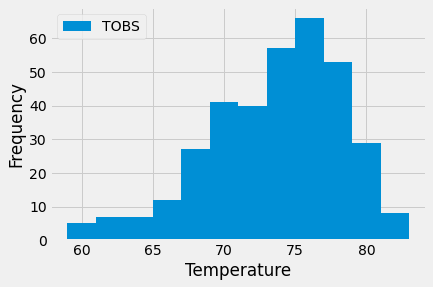

In [61]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# ref: http://localhost:8889/notebooks/Desktop/10-Advanced-Data-Storage-and-Retrieval/3/Activities/01-Ins_Joins/Solved/Ins_Joins.ipynb
# ref: https://docs.sqlalchemy.org/en/14/orm/query.html
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# ref: https://stackoverflow.com/questions/35456489/legend-not-showing-the-full-text

tob_waihee_query = session.query(Measurements.date, Measurements.tobs).\
                    filter(Measurements.date >= query_startdate).\
                    filter(Measurements.date <= query_enddate[0]).\
                    filter(Measurements.station == max_activestation[0]).\
                    order_by(Measurements.date.desc()).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
waihee_df = pd.DataFrame([{ "Date": query[0],
                                "TOBS": query[1]} for query in tob_waihee_query])

bins = 12
legend = ('TOBS',)
waihee_hist = plt.hist(waihee_df["TOBS"], bins)
x = plt.xlabel('Temperature')
y = plt.ylabel('Frequency')
lngd = plt.legend(legend, loc ='upper left')

# Close session

In [19]:
# Close Session
session.close()